In [ ]:
import os
# !pip install unrar
# !unrar x '/content/drive/MyDrive/Fatepura_satellite_dataset_800_altitude/800_dataset_with_semantic_segmentation.rar'

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")
%matplotlib inline
import gc

from tqdm.notebook import trange, tqdm

from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import Conv2D, Input, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K


import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.callbacks import *

import random

## Seeding
seed = 2019
random.seed = seed
np.random.seed = seed
tf.seed = seed

In [ ]:
# Check if rasterio is installed,
# if not, install it
try:
    import rasterio
except:
    !pip install rasterio
    import rasterio


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.7 MB/s eta 0:00:00


In [3]:
w, h = 256,256
border = 5

In [7]:
ids = next(os.walk("/content/drive/MyDrive/Applied_ML/Project/data/S2Hand/.*"))[2] # list of names all images in the given path
print("No. of images = ", len(ids))

StopIteration: ignored

# **Data Reading and Train test split**

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import glob
train = sorted(glob.glob("/content/drive/MyDrive/Course Materials/Applied_ML/Project/data/S2Hand/*"))
train_mask = sorted(glob.glob("/content/drive/MyDrive/Course Materials/Applied_ML/Project/data/LabelHand/*.tif"))
print(f'Total Train Images : {len(train)}\nTotal Mask Image : {len(train_mask)}')

Total Train Images : 446
Total Mask Image : 446


In [10]:
def resize_train_img(img_path, w, h):
  src = rasterio.open(img_path)
  img = src.read()
  img = np.moveaxis(img, 0, 2)
  img_resize = cv2.resize(img, (w, h), interpolation = cv2.INTER_NEAREST)
  profile = src.profile
  profile.update(width=w, height=h)
  out_path = os.path.join('/content/drive/MyDrive/Applied_ML/Project/data/resized/', os.path.basename(img_path))
  img_resize = np.moveaxis(img_resize, 2, 0)
  with rasterio.open(out_path, 'w', **profile) as dst:
    dst.write(img_resize)



In [11]:
def resize_mask_img(img_path, w, h):
  src = rasterio.open(img_path)
  img = src.read()
  img = np.moveaxis(img, 0, 2)
  img_resize = cv2.resize(img, (w, h), interpolation = cv2.INTER_NEAREST)
  profile = src.profile
  profile.update(width=w, height=h)
  out_path = os.path.join('/content/drive/MyDrive/Applied_ML/Project/data/resized/mask', os.path.basename(img_path))
  with rasterio.open(out_path, 'w', **profile) as dst:
    dst.write(img_resize,1)


In [12]:
import glob

In [13]:
resized_train = sorted(glob.glob("/content/drive/MyDrive/Applied_ML/Project/data/resized/*.tif"))
resized_train_mask = sorted(glob.glob("/content/drive/MyDrive/Applied_ML/Project/data/resized/mask/*.tif"))

In [15]:
resized_train[0].shape

IndexError: ignored

In [ ]:
X = np.zeros((len(resized_train),h, w, 13), dtype=np.float32)
y = np.zeros((len(resized_train_mask), h, w,1), dtype=np.float32)

In [ ]:
X.shape

(446, 256, 256, 13)

# Scaling Data

In [ ]:
scaler = StandardScaler()

In [ ]:
scaler_minmax = MinMaxScaler()

In [ ]:
src = rasterio.open(resized_train[2])

In [ ]:
x_img = src.read()

In [ ]:
x_img.shape

(13, 256, 256)

In [ ]:
x_img.min()

6

In [ ]:
x_img = np.moveaxis(x_img,0,2)

In [ ]:
x_img.shape

(256, 256, 13)

In [ ]:
y = scaler_minmax.fit_transform(x_img.reshape(-1, x_img.shape[-1])).reshape(x_img.shape)

In [ ]:
y.shape

(256, 256, 13)

In [ ]:
y.min()

0.0

In [ ]:
mask_img[mask_img ==-1.0] = 0.0

In [ ]:
mask_img.shape

(256, 256, 1)

In [ ]:
mask_img = mask_img[np.newaxis,:, :, :]

In [ ]:
mask_img.shape

(1, 256, 256, 1)

In [ ]:
mask_img[0].shape

(256, 256, 1)

In [ ]:
mask_img.shape

(1, 256, 256, 1)

In [ ]:
y = scaler.fit_transform(mask_img.reshape(-1, mask_img.shape[-1])).reshape(mask_img.shape)

In [ ]:
y[0].min()

-0.0771729885801397

In [ ]:

for n, (img, mimg) in tqdm(enumerate(zip(resized_train, resized_train_mask))):
  # print(n, img, mimg)
  # Load images
  src = rasterio.open(img)
  x_img = src.read()
  x_img = np.moveaxis(x_img,0,2)
  x_img = x_img[np.newaxis,:, :, :]
  x_img_scaled = scaler_minmax.fit_transform(x_img.reshape(-1, x_img.shape[-1])).reshape(x_img.shape)

  # img_false = np.dstack((primary_img[:, :, 0], primary_img[:, :, 7], primary_img[:, :, 11]))
  # img = load_img(img)
  # x_img = img_to_array(img_false)

  # x_img = resize(x_img, (h, w, 13), mode = 'constant', preserve_range = True)
  # # Load masks
  mask = rasterio.open(mimg)
  mask_img = mask.read()
  mask_img = np.moveaxis(mask_img,0,2)
  mask_img[mask_img ==-1.0] = 0.0
  #mask_img = mask_img[np.newaxis,:, :, :]
  #mask_img_scaled = scaler.fit_transform(mask_img.reshape(-1, mask_img.shape[-1])).reshape(mask_img.shape)
  # mask = resize(mask_img, (h, w, 1), mode = 'constant', preserve_range = True)
  X[n] = x_img_scaled
  y[n] = mask_img

  # # Save images
  #train_list.append(x_img)
  #mask_list.append(mask_img)


0it [00:00, ?it/s]

In [ ]:
y.mean()

0.09159978

In [ ]:
X.mean()

0.30579448

In [ ]:
#train_list = []
#mask_list = []
#for n, (img, mimg) in tqdm(enumerate(zip(resized_train, resized_train_mask))):
  # print(n, img, mimg)
  # Load images
  #src = rasterio.open(img)
  #x_img = src.read()
  # img_false = np.dstack((primary_img[:, :, 0], primary_img[:, :, 7], primary_img[:, :, 11]))
  # img = load_img(img)
  # x_img = img_to_array(img_false)

  # x_img = resize(x_img, (h, w, 13), mode = 'constant', preserve_range = True)
  # # Load masks
  #mask = rasterio.open(mimg)
  #mask_img = mask.read()
  # mask = resize(mask_img, (h, w, 1), mode = 'constant', preserve_range = True)
  # # Save images
  #train_list.append(x_img)
  #mask_list.append(mask_img)


0it [00:00, ?it/s]

In [ ]:
# Save the files in Numpy array for reusability
np.save('/content/drive/MyDrive/Applied_ML/Project/data/XandY/X3.npy', X)
np.save('/content/drive/MyDrive/Applied_ML/Project/data/XandY/y3.npy', y)
print(X.shape, y.shape)
#X = np.load('/content/drive/MyDrive/Applied_ML/Project/data/XandY/X3.npy')
#y = np.load('/content/drive/MyDrive/Applied_ML/Project/data/XandY/y3.npy')
print(X.shape, y.shape)

(446, 256, 256, 13) (446, 256, 256, 1)
(446, 256, 256, 13) (446, 256, 256, 1)


In [ ]:
# Split train and valid
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
gc.collect()

(401, 256, 256, 13) (401, 256, 256, 1) (45, 256, 256, 13) (45, 256, 256, 1)


480

# **Visualization the image and It masks**

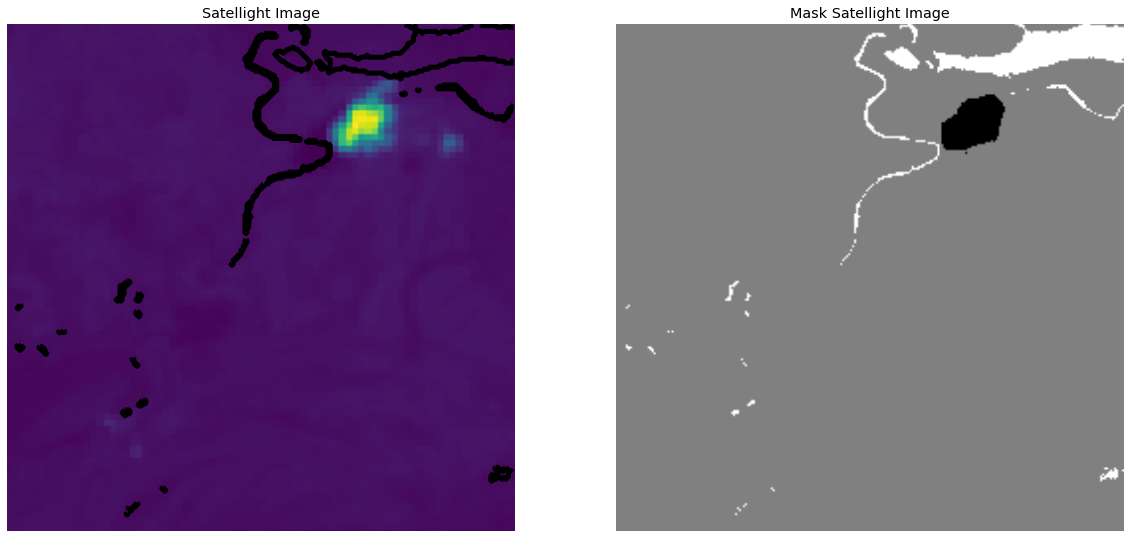

In [ ]:
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0 # salt indicator

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 15))

ax1.imshow(X_train[ix, ..., 0], interpolation = 'bilinear')
if has_mask: # if salt
    # draw a boundary(contour) in the original image separating salt and non-salt areas
    ax1.contour(y_train[ix].squeeze(), colors = 'k', linewidths = 5, levels = [0.5])
ax1.set_title('Satellight Image')
ax1.set_axis_off()
ax2.imshow(y_train[ix].squeeze(), cmap = 'gray', interpolation = 'bilinear')
ax2.set_title('Mask Satellight Image')
ax2.set_axis_off()

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32)
valset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

In [ ]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

In [ ]:
def Unet(input_img, n_filters = 16, dropout = 0.1, batchnorm = True):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)

    # Expansive Path
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)

    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)

    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)

    u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding = 'same')(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [ ]:
h,w = 256,256

In [ ]:
from keras import backend as K
K.clear_session()

input_img = Input((h, w, 13), name='img')
model = Unet(input_img, n_filters=16, dropout=0.05, batchnorm=True)
metrics = ["accuracy",
           tf.keras.metrics.AUC(),
           tf.keras.metrics.SensitivityAtSpecificity(0.5),
           tf.keras.metrics.SpecificityAtSensitivity(0.5)]
#metrics_iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])
model.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=metrics)
gc.collect()

335

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img (InputLayer)               [(None, 256, 256, 1  0           []                               
                                3)]                                                               
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 16  1888        ['img[0][0]']                    
                                )                                                                 
                                                                                                  
 batch_normalization_1 (BatchNo  (None, 256, 256, 16  64         ['conv2d_1[0][0]']               
 rmalization)                   )                                                             

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-Unet.h5', verbose=1, save_best_only=True, save_weights_only=True),
    CSVLogger("dataResUnet.csv"),
    TensorBoard(log_dir='./logs')
]

In [ ]:
results = model.fit(X_train, y_train, batch_size=6, epochs=5, callbacks=callbacks, validation_data=(X_test, y_test), use_multiprocessing=True)

Epoch 1/5
 4/67 [>.............................] - ETA: 4:23 - loss: 0.3994 - accuracy: 0.8631 - auc: 0.7816 - sensitivity_at_specificity: 0.8578 - specificity_at_sensitivity: 0.8675

In [ ]:
df_result = pd.DataFrame(results.history)
df_result.sort_values('val_loss', ascending=True, inplace = True)
df_result

,loss,accuracy,auc,sensitivity_at_specificity,specificity_at_sensitivity,val_loss,val_accuracy,val_auc,val_sensitivity_at_specificity,val_specificity_at_sensitivity,lr
3,-1.005811,0.810077,0.418895,0.408129,0.088716,-1.612996,0.834670,0.497948,0.479922,0.176064,0.001
4,-1.449028,0.810135,0.441234,0.431709,0.076585,-0.790249,0.847956,0.514931,0.514965,0.741731,0.001
2,-0.576746,0.804889,0.426507,0.411915,0.109073,-0.254987,0.739310,0.489489,0.487986,0.236596,0.001
1,-0.229775,0.795832,0.440695,0.422758,0.190605,0.449310,0.778379,0.763469,0.854207,0.826141,0.001
0,0.189184,0.597016,0.443487,0.431518,0.245964,3.012777,0.635072,0.544839,0.554886,0.639769,0.001


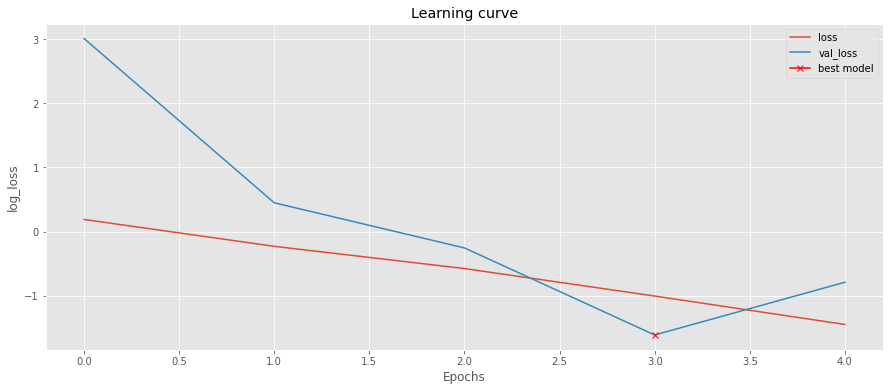

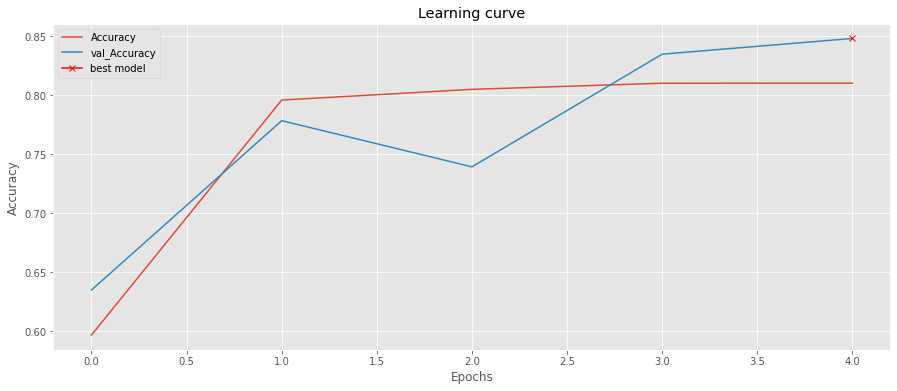

In [ ]:
plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

plt.figure(figsize = (15,6))
plt.title("Learning curve")
plt.plot(results.history["accuracy"], label="Accuracy")
plt.plot(results.history["val_accuracy"], label="val_Accuracy")
plt.plot(np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend();

# **Inference**

In [ ]:
model.load_weights('model-Unet.h5')

In [ ]:
model.evaluate(X_test, y_test, verbose=1)

2/2 [==============================] - 6s 2s/step - loss: -1.6130 - accuracy: 0.8347 - auc: 0.4979 - sensitivity_at_specificity: 0.4799 - specificity_at_sensitivity: 0.1761


[-1.6129961013793945,
 0.8346700072288513,
 0.4979475438594818,
 0.47992244362831116,
 0.1760641485452652]

In [ ]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_test, verbose=1)

2/2 [==============================] - 7s 2s/step


In [ ]:
# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [ ]:
def plot_sample(X, y, preds, binary_preds, ix=None):
    """Function to plot the results"""
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellight Image')
    ax[0].set_axis_off()

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Satellight Mask Image')
    ax[1].set_axis_off()

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Satelight Image Predicted')
    ax[2].set_axis_off()

    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Satellight Mask Image Predicted binary');
    ax[3].set_axis_off()

# **Predictions on training set**

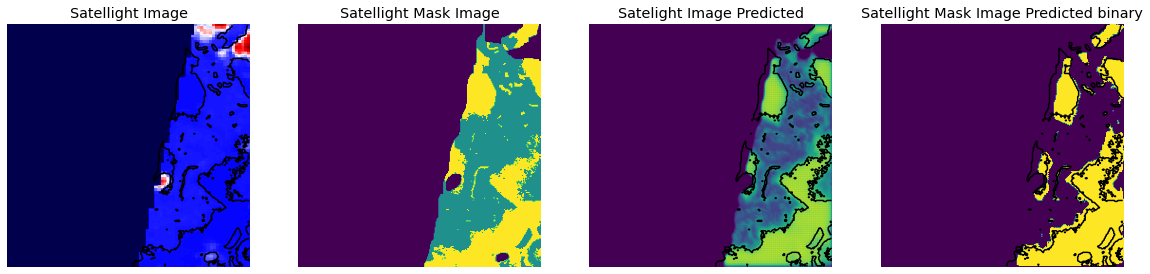

In [ ]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train, preds_train_t, ix=14)

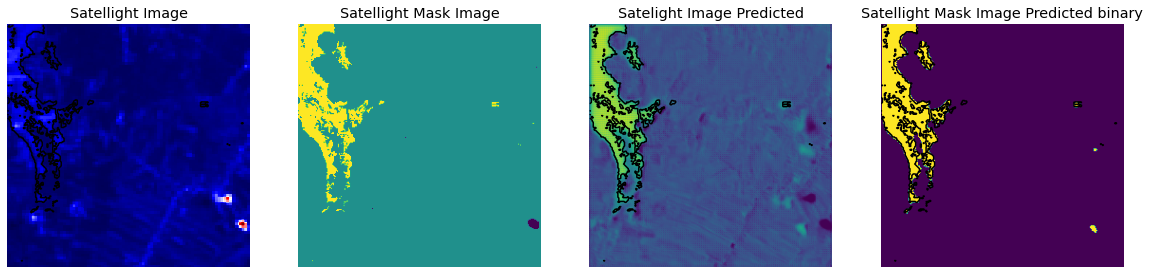

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

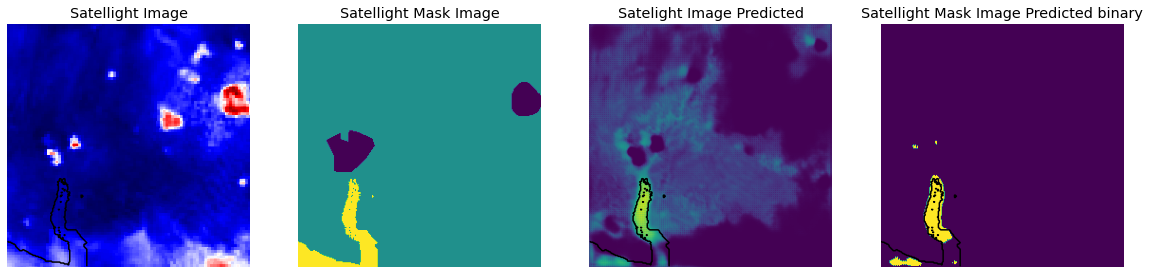

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

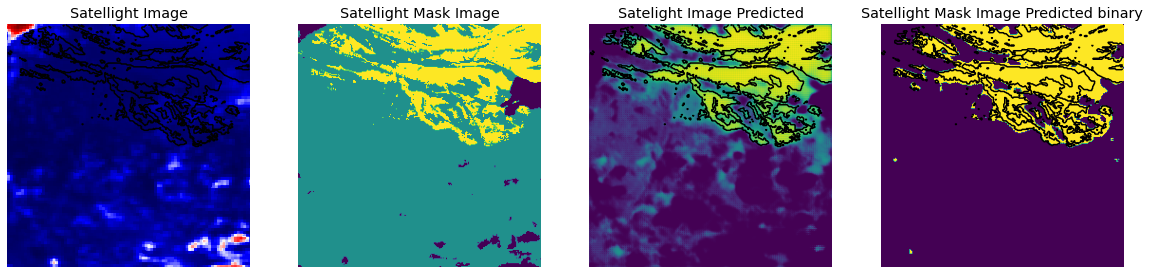

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

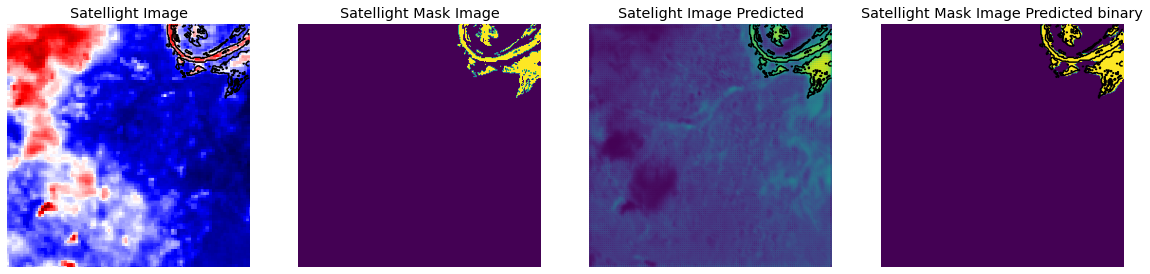

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

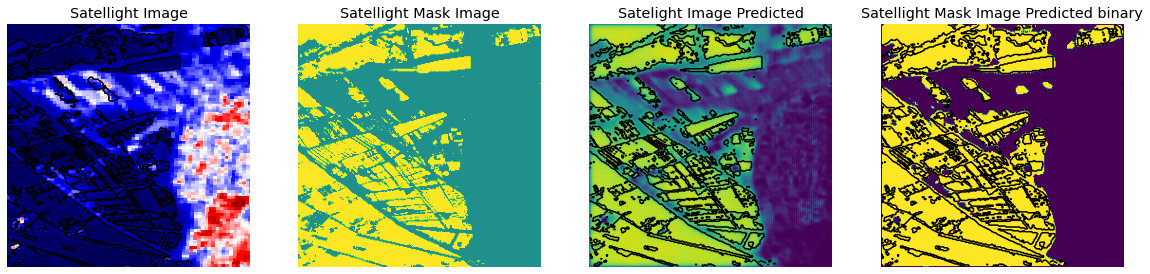

In [ ]:
plot_sample(X_train, y_train, preds_train, preds_train_t)

In [ ]:
def build_model(hp, input_img, batchnorm=True, dropout=0.1):
    c1 = conv2d_block((filters=hp.Int('conv_1_filter', min_value=8, max_value=16, step=4),
         kernel_size=hp.Choice('conv_1_kernel', values = [3,5])),
         input_shape=(256,256,13)), batchnorm = batchnorm)
    # adding second convolutional layer
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block((filters=hp.Int('conv_2_filter', min_value=16, max_value=32, step=8),
         kernel_size=hp.Choice('conv_2_kernel', values = [3,5])), batchnorm = batchnorm)(p1)
    # adding second convolutional layer
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block((filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
         kernel_size=hp.Choice('conv_3_kernel', values = [3,5])), batchnorm = batchnorm)(p2)
    # adding second convolutional layer
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block((filters=hp.Int('conv_4_filter', min_value=64, max_value=128, step=32),
         kernel_size=hp.Choice('conv_4_kernel', values = [3,5])), batchnorm = batchnorm)(p3)
    # adding second convolutional layer
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)

    c5 = conv2d_block((p4,(filters=hp.Int('conv_5_filter', min_value=128, max_value=256, step=64),
         kernel_size=hp.Choice('conv_5_kernel', values = [3,5])),batchnorm = batchnorm)

    u6 = Conv2DTranspose((filters=hp.Int('conv_6_filter', min_value=64, max_value=128, step=32),
         kernel_size=hp.Choice('conv_6_kernel', values = [3,5])), strides=(2,2), padding='same'))(c5)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, (filters=hp.Int('conv_6_filter', min_value=64, max_value=128, step=32)), batchnorm = batchnorm)


    u7 = Conv2DTranspose((filters=hp.Int('conv_7_filter', min_value=32, max_value=64, step=16),
         kernel_size=hp.Choice('conv_7_kernel', values = [3,5])), strides=(2,2), padding='same'))(c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, (filters=hp.Int('conv_7_filter', min_value=32, max_value=64, step=16)), batchnorm = batchnorm)

    u8 = Conv2DTranspose((filters=hp.Int('conv_8_filter', min_value=16, max_value=32, step=8),
         kernel_size=hp.Choice('conv_8_kernel', values = [3,5])), strides=(2,2), padding='same'))(c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, (filters=hp.Int('conv_8_filter', min_value=16, max_value=32, step=32)), batchnorm = batchnorm)

    u9 = Conv2DTranspose((filters=hp.Int('conv_9_filter', min_value=8, max_value=16, step=4),
         kernel_size=hp.Choice('conv_9_kernel', values = [3,5])), strides=(2,2), padding='same'))(c8)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u8, (filters=hp.Int('conv_9_filter', min_value=8, max_value=16, step=4)), batchnorm = batchnorm)

    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])

    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    return model